# Objective 

논문을 참고하여, DeepLab V3+를 구현하도록 하겠습니다. 이 과정은 코드를 점검하는 과정이기도 합니다. 

[Encoder-Decoder with Atrous Separable Convolution for Semantic ](https://eccv2018.org/openaccess/content_ECCV_2018/papers/Liang-Chieh_Chen_Encoder-Decoder_with_Atrous_ECCV_2018_paper.pdf)

In [1]:
%matplotlib inline
import sys
sys.path.append("../")

from tensorflow.python.keras.layers import Layer, InputSpec, Input
from tensorflow.python.keras.layers import Concatenate, UpSampling2D
from tensorflow.python.keras.layers import Conv2D, BatchNormalization
from tensorflow.python.keras.layers import ReLU, ZeroPadding2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras import backend as K
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

# DeepLabv3+ Architecture의 구성
![Imgur](https://i.imgur.com/QoB4pw4.png)

기본적으로는 위와 같이 Encoder와 Decoder의 구조로 만들어져 있습니다. DeepLabv3+이 DeepLabv3과 조금 달라진 것 중 하나가 바로 Low-Level Features를 바로 있는 Skip Connection이 추가되었다는 점입니다. 위를 바탕으로 우리는 크게 세 부분으로 나누어 접근해보도록 하겠습니다.

![Imgur](https://i.imgur.com/RGdwLEK.jpg)

# BackBone Network

![Imgur](https://i.imgur.com/iP5B50l.jpg)

마지막 1개 혹은 2개의 stride을 1로 만들어 줌으로써, 좀 더 OS(output stride)의 크기가 작아지도록 했습니다. 이를 위해서는 재학습이 필요합니다. 이후에 ImageNet을 확보해 모델을 학습, 진행하도록 하겠습니다.<br>

### (1) 전처리 Layer 구성하기

기본적으로 학습된 모델은 아래와 같이 전처리를 수행해주어야 합니다. 이를 그래프 내에 포함시킴으로써, 데이터 파이프라인을 간결하게 만들어주도록 하겠습니다.

In [2]:
class MeanShift(Layer):
    """MobileNet의 Input 형태로 바꾸어주는 Layer
    1. (0,255) -> (-1,1)
    2. BGR -> RGB
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, x):
        x = x / 127.5 - 1.
        return K.reverse(x, axes=3)

    def compute_output_shape(self, input_shape):
        return input_shape


### (2) Backbone Network 가져오기

Keras에서 제공하는 pretrained Model 중 하나인 MobileNetV2를 가져오도록 하겠습니다.<br>
기본적으로 Real-Time 처리를 목표로 하고 있기 때문입니다.

In [3]:
from tensorflow.python.keras.applications import MobileNetV2

inputs = Input(shape=(None,None,3))
preprocess = MeanShift()(inputs)  # (0,255) -> (-1, 1)
backbone = MobileNetV2(input_tensor=preprocess,
                       alpha=1.4,
                       include_top=False)

/Users/ksj/anaconda3/envs/tf2.0/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


| Feature Map Name | OS |
| ---- | ---- |
| block_1_expand_relu | 2 |
| block_3_expand_relu | 4 |
| block_6_expand_relu | 8 |
| block_13_expand_relu | 16 |
| block_16_project_BN | 32 |

![Imgur](https://i.imgur.com/eXVrB4U.png)

### (3) Feature Map 가져오기

여기에서 Encoder-Decoder with Atrous Conv에서는 OS16와 OS4에서 각각 가져왔습니다. 마지막 Stride를 제거한 형태로, Backbone을 재설계하여 학습하면 보다 성능이 나을 거라 기대되지만, 일단은 기존 Model의 것으로 가져오도록 하겠습니다.


In [4]:
# OS 4
skip_input = backbone.get_layer('block_3_expand_relu').output
# OS 16
aspp_input = backbone.get_layer('block_13_expand_relu').output

# ASPP Module

Astrous Spatial Pyramid Pooling 기법은 Multi-Scale에 따라 유연하게 반응할 수 있고, 적은 Parameter 수로도 넓은 Receptive Field를 관찰할 수 있다는 점에서 매우 좋은 아이디어 입니다.

![Imgur](https://i.imgur.com/MThf6TM.png)

논문에서는 
* Rate : (6, 12, 18)
* #of Features : 256
<br>
개 만큼을 이용하였고, Rate : 24 대신 Global Average Pooling을 통해 전체 이미지에 대한 Context를 추가하는 부분을 만들었습니다.

### (1) ResizeLike Layer 구현

우리는 UpSamplingBilinear2D 구간이 존재합니다. 보다 다양한 이미지 사이즈에서 올바르게 동작하기 위해서는 크기를 UpSampling size 배수만큼 곱해주는 UpSamplingBilinear2D보다, `tf.image.resize`를 활용하여, 배수가 아니더라도 동작하도록 구현하는 것이 보다 좋다고 판단하였습니다.

In [5]:
class ResizeLike(Layer):
    """Change the size of tensor(height & width) to target node"""

    def __init__(self, target_node, data_format=None,
                 align_corners=True, **kwargs):
        data_format = K.image_data_format()
        self.data_format = data_format
        self.input_spec = [InputSpec(ndim=4)]

        self.align_corners = align_corners

        if target_node.shape[1] is None:
            self.target_shape = tf.shape(target_node)
        else:
            self.target_shape = target_node.shape
        self.target_size = (self.target_shape[1], self.target_shape[2])
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        resize = tf.compat.v1.image.resize
        return resize(inputs, self.target_size,
                      align_corners=self.align_corners)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.target_size[0],
                self.target_size[1], input_shape[3])

### (2) AtrousSeparableConvBN Layer 구현

![Imgur](https://i.imgur.com/m8hf30B.png)

이 논문에서의 주요한 발견 중 하나는 Atrous Convolution과 Depthwise Separable Convolution을 동시에 사용하여 Receptive Field를 늘리면서도 획기적으로 Parameter의 수를 줄였다는 것에 있습니다.

In [7]:
from models.normalization import GroupNormalization

def AtrousSeparableConvBN(x, filters, prefix, stride=1,
                          kernel_size=3, dilation_rate=1):
    """ Atrous Separable Convolution Layer with Batch Normalization
        Operation Order : 
           Atrous & Depthwise Convolution 
        -> Batch Normalization 
        -> Activation 
        -> Pointwise Convolution 
        -> Activation

        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            dilation_rate: specifying the dilation rate
    """
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = (kernel_size + 
                                 (kernel_size - 1) * (dilation_rate - 1))
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    # Atrous Depthwise Convolution
    x = DepthwiseConv2D((kernel_size, kernel_size), (stride, stride), 
                        dilation_rate=dilation_rate,
                        padding=depth_padding, use_bias=False, 
                        name=prefix+'_depthwise')(x)
    x = BatchNormalization(name=prefix+'_depthwise_BN', epsilon=1e-5)(x)
    x = ReLU()(x)

    # Pointwise Convolution
    x = Conv2D(filters, (1, 1), use_bias=False,
               name=prefix+'_pointwise')(x)
    x = BatchNormalization(name=prefix+'_pointwise_BN', epsilon=1e-5)(x)
    x = ReLU()(x)
    return x

### (3) ASPP Module 적용

![Imgur](https://i.imgur.com/FdcykWh.png)

In [8]:
from models.normalization import GroupNormalization

atrous_rate = (6, 12, 18)
num_features = 256

aspp_branches = []
# ASPP 1x1 Branch
aspp = Conv2D(num_features, (1, 1), use_bias=False,
              name='aspp_1x1')(aspp_input)
aspp = BatchNormalization(name='aspp_1x1_BN',
                          epsilon=1e-5)(aspp)
aspp = ReLU()(aspp)
aspp_branches.append(aspp)

# ASPP Branches
for rate in atrous_rate:
    aspp = AtrousSeparableConvBN(aspp_input, num_features, 
                                 f'aspp_{rate}', dilation_rate=rate)
    aspp_branches.append(aspp)

# ASPP Pooling Branch
aspp = tf.reduce_mean(inputs, axis=-1, keepdims=True,
                      name='aspp_pool')
aspp = Conv2D(num_features, (1, 1), use_bias=False)(aspp)
aspp = ReLU()(aspp)
aspp = ResizeLike(target_node=aspp_input)(aspp)

aspp_branches.append(aspp)

# Concatenation & projection
aspp_concat = Concatenate(name='aspp_concat')(aspp_branches)
x = Conv2D(num_features, (1,1), use_bias=False,
           name='concat_projection')(aspp_concat)
x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
encoded_fmap = ReLU()(x)

# Decoder

DeepLabv3+에서는 Decoder 부분을 좀 더 강화하였습니다. UNET 같은 모델에서 제안한 Skip Connection을 이용하여, 저차원의 고해상도 정보를 집어넣어 줌으로써 Detail을 살리려 했습니다.

![Imgur](https://i.imgur.com/1UIoKdk.png)

### (1)  Low-level Features

바로 Low-Level Features의 채널을 그대로 Concat을 해주게 되면, 지나치게 Low_level의 정보가 중요하게 들어가게 됩니다. ASPP Module에서 Encoding된 정보보다 더 중요하게 판단되어 지기 때문에, 여기에서는 1x1 Convolution으로 줄여주게 됩니다.

In [10]:
num_skip_features = 48

skip = Conv2D(num_skip_features, (1, 1), use_bias=False,
              name='skip_projection')(skip_input)
skip = BatchNormalization(name='skip_projection_BN')(skip)
skip = ReLU()(skip)

### (2) Concat Features

Low Level 해상도에서 가져온 FeatureMap은 ASPP Module의 Feature Map보다 크기가 큽니다. <br>
Concat을 하기 위해 이미지의 크기를 맞추어주기 위해서 우리는 Upsampling을 적용해야 합니다.

In [11]:
upsampled = ResizeLike(skip)(encoded_fmap)
concat_features = Concatenate()([upsampled, skip])

### (3) Convolution for Refining feature

Concat Features한 것에다가 3x3 Convolution을 몇 개 붙임으로써, 보정하는 효과를 갖습니다. 이때 256개의 3x3 Convolution 2개를 붙였을때 제일 큰 성능향상을 보였다고 합니다.

Decoder의 Convolution이 AtrousSeparableConvBN인지, 기존 Batch Normalization인지 나타나있지 않아서, 여기서는 conv2D로 가도록 하겠습니다.

Bias를 쓰지 않는 이유

````
The authors also do not use any bias terms and noticed that it does not lead to any loss of accuracy. They also employ early downsampling – Figure 4(C), which reduces the image dimensions and hence saves on costly computations at the beginning of the network. Using dilated convolutions also makes sure that the network has a wider receptive field and saves them from aggressive downsampling early on in the network.
````

In [12]:
num_features = 256
num_classes = 7
num_depth = 2
use_separable_conv = False

for i in range(num_depth):
    if use_separable_conv:
        x = AtrousSeparableConvBN(x, num_features, f'decoder_conv{i}')
    else:
        x = Conv2D(num_features, (3, 3), use_bias=False,
                   padding='same', name=f'decoder_conv{i}')(x)
        x = BatchNormalization(epsilon=1e-5,name=f'decoder_conv{i}_BN')(x)
        x = ReLU(name=f'decoder_conv{i}_relu')(x)

### (4) prediction label

우리는 크게 기본라벨과 Abnormal 라벨로 나뉘어 집니다. Abnormal의 경우, 라벨링이된 것과 안된 것이 나뉘어지기 때문에, Abnormal의 라벨이 존재하는 경우에만 학습할 수 있도록 따로 구성하였습니다.

In [13]:
label_pred = Conv2D(num_classes, (1, 1), name='label_logits')(x)
label_pred = ResizeLike(backbone.input,
                        name='label_prediction')(label_pred)

abnormal_pred = Conv2D(1, (1, 1), activation='sigmoid',name='abnormal_logits')(x)
abnormal_pred = ResizeLike(backbone.input,
                           name='abnormal_prediction')(abnormal_pred)

outputs = [label_pred, abnormal_pred]

In [14]:
model = Model(inputs,outputs)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
mean_shift (MeanShift)          (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           mean_shift[0][0]                 
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 4 1296        Conv1_pad[0][0]                  
______________________________________________________________________________________________

----

## 구성 정리

위의 모든 요소들을 정리해서 하나의 Configuration Object로 정리하여 구성하면 아래와 같습니다.

In [16]:
class ModelConfig:
    # BackBone Network에 대한 설정
    BACKBONE = "MobileNetV2"
    BACKBONE_INPUT_SHAPE = (None, None, 3)
    BACKBONE_ALPHA = 1.4
    BACKBONE_LOW_FEATURE_MAP_NAME = 'block_3_expand_relu'
    BACKBONE_HIGH_FEATURE_MAP_NAME = "block_13_expand_relu"

    # ASPP Network에 대한 설정
    ASPP_NUM_FEATURES = 256
    ASPP_ATROUS_RATE = (6, 12, 18)

    # Decoder Network에 대한 설정
    NUM_CLASSES = 8
    DECODER_NUM_DEPTH = 2
    DECODER_NUM_FEATURES = 256
    DECODER_NUM_SKIP_FEATURES = 48
    DECODER_USE_SEPARABLE_CONV = False
    SEPARATE_ABNORMAL_NETWORK = True    

    def __init__(self, config_dict=None):
        if config_dict is not None:
            if 'ModelConfig' in config_dict:
                config_dict = config_dict['ModelConfig']
            for key, value in config_dict.items():
                self.__setattr__(key, value)    
    
    def to_dict(self):
        """ Convert Configuration Attributes to dict Object
        :return:
        """
        return {name: getattr(self, name)
                for name in dir(self) if name.isupper()}

### (1) 모델 구성하기

In [17]:
from models import DeepLabV3, ModelConfig

In [27]:
config = ModelConfig()
model = DeepLabV3(config)

### (2) BackBone Network 동결하기

In [30]:
# Task-Specific Network만 학습하기 위해, Freezing Backbone Network
for idx, layer in enumerate(model.layers):
    layer.trainable = False
    if layer.name == ModelConfig.BACKBONE_HIGH_FEATURE_MAP_NAME:
        break
        
model.summary()

Model: "deeplabv3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
mean_shift_4 (MeanShift)        (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           mean_shift_4[0][0]               
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 4 1296        Conv1_pad[0][0]                  
__________________________________________________________________________________________

### (3) Loss Function 정의하기 

논문에는 따로 명시되진 않았지만, 우리는 사물의 경계선 부분들을 지울 예정입니다. 우리의 사물 Bounding Box는 약간 Coarse한 경향이 있어서<br>
외곽의 명료하지 않은 부분 정보를 날려줌으로써, 노이즈를 줄일 것입니다.

In [31]:
from utils import CrackDataset, label_to_color_image

dataset = CrackDataset("../datasets/pavement_crack/")
image, label = dataset[3]

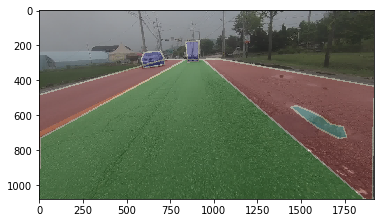

In [32]:
plt.imshow(image)
plt.imshow(label_to_color_image(label),alpha=0.3)
plt.show()

라벨 기준은 아래와 같습니다. 우리는 ignore을 항상 255로 둘 예정입니다.

In [33]:
LABEL_MAP = {
    "background": 0,
    "other_road": 1,
    "my_road": 2,
    "manhole": 3,
    "car": 4,
    "steel": 5,
    "pothole": 6,
    "bump": 7,
    "abnormal": 8,
    'ignore': 255
}

In [34]:
from models import CrackGenerator

data_gen = CrackGenerator("../datasets/pavement_crack/",
                          crop_size=(200,200), batch_size=2,
                          random_crop=True, random_flip=True)

images, labels = data_gen[0]

In [35]:
from models.losses import sparse_categorical_crossentropy_with_ignore
from models.losses import binary_crossentropy_with_ignore
from models.optimizer import AdamW

In [36]:
model.compile(AdamW(lr=7e-4),
              loss={
                  "label_prediction":sparse_categorical_crossentropy_with_ignore(255),
                  "crack_prediction":binary_crossentropy_with_ignore(255),
              },
              loss_weights={
                  "label_prediction":1.,
                  "crack_prediction":10.,
              }
             )

In [37]:
model.train_on_batch(images,labels)

W0702 13:52:38.074181 4718646720 deprecation.py:323] From /Users/ksj/anaconda3/envs/tf2.0/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[4.751398, 2.7524037, 0.19989944]